In [1]:
import os.path as op
import time
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tools
from imp import reload
reload(tools)
from tools import syn_registration, affine_registration
%matplotlib inline


import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
import dipy.data as dpd

In [2]:
import nibabel as nib
import dipy.data as dpd
import os

In [3]:
afqpath = '/Users/arokem/source/AFQ/'
# afqpath = '/home/jyeatman/git/afq'

In [4]:
ni, gtab = dpd.read_stanford_hardi()

In [5]:
hardi_data = ni.get_data()
hardi_affine = ni.get_affine()

In [6]:
b0 = hardi_data[..., gtab.b0s_mask]

In [7]:
mean_b0 = np.mean(b0, -1)

In [8]:
ni_b0 = nib.Nifti1Image(mean_b0, hardi_affine)

In [9]:
ni_b0.to_filename('mean_b0.nii')

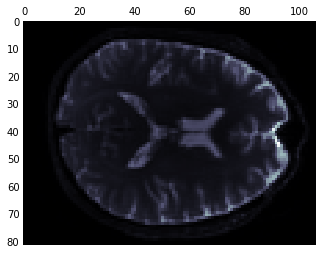

In [10]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)

In [11]:
MNI_T2 = nib.load(op.join(afqpath, 'templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii'))

In [12]:
MNI_T2_data = MNI_T2.get_data()

In [13]:
MNI_T2_affine = MNI_T2.get_affine()

In [14]:
#xformed_b0, affine = affine_registration(mean_b0, MNI_T2_data, 
#                                         moving_grid2world=hardi_affine, 
#                                         static_grid2world=MNI_T2_affine)

In [15]:
#plt.matshow(xformed_b0[:, :, xformed_b0.shape[-1]//2], cmap=cm.bone)
#plt.matshow(MNI_T2_data[:, :, MNI_T2_data.shape[-1]//2], cmap=cm.bone)

In [16]:
warped_b0, mapping = syn_registration(mean_b0, MNI_T2_data,
                                      moving_grid2world=hardi_affine, 
                                      static_grid2world=MNI_T2_affine, 
                                      metric='CC', dim=3, level_iters = [10, 10, 5], 
                                      #prealign=affine.affine)
                                      prealign=None)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


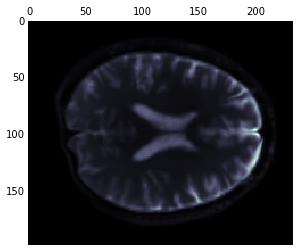

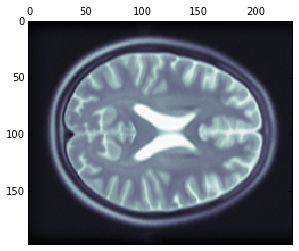

In [17]:
plt.matshow(warped_b0[:,:,warped_b0.shape[-1]//2], cmap=cm.bone)
plt.matshow(MNI_T2_data[:, :, MNI_T2_data.shape[-1]//2], cmap=cm.bone)

In [18]:
new_ni = nib.Nifti1Image(warped_b0, MNI_T2_affine)

In [19]:
new_ni.to_filename('./warped_b0.nii.gz')

In [20]:
LOCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/L_Occipital.nii.gz'))
ROCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/R_Occipital.nii.gz'))
midsag_ni = nib.load(os.path.join(afqpath,'templates/callosum2/Callosum_midsag.nii.gz'))

In [21]:
LOCC_data = LOCC_ni.get_data()
ROCC_data = ROCC_ni.get_data()
midsag_data = midsag_ni.get_data()

In [22]:
midsag_affine = midsag_ni.get_affine()

In [23]:
midsag_data = midsag_ni.get_data()

In [24]:
warped_midsag = mapping.transform_inverse(midsag_data)

In [25]:
#bin_warped_LOCC = np.ceil(warped_LOCC)
bin_warped_midsag = np.ceil(warped_midsag)

In [26]:
im = np.sum(np.ceil(bin_warped_midsag), axis=0)

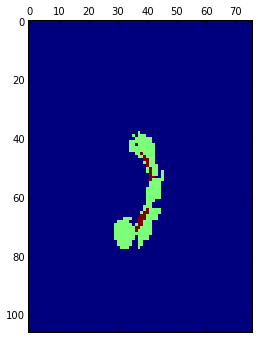

In [27]:
plt.matshow(im)

In [28]:
import scipy.ndimage as ndim

In [29]:
#filled_warped_LOCC= ndim.binary_dilation(bin_warped_LOCC, iterations=1).astype(int)
filled_warped_midsag= ndim.binary_fill_holes(bin_warped_midsag.astype(int)).astype(int)

In [30]:
np.unique(filled_warped_midsag)

array([0, 1])

In [31]:
filled_warped_midsag.shape

(81, 106, 76)

In [32]:
filled_warped_midsag_ni = nib.Nifti1Image(filled_warped_midsag, hardi_affine)

In [33]:
filled_warped_midsag_ni.to_filename('./warped_midsag.nii.gz')

In [34]:
im = np.sum(np.ceil(ndim.binary_fill_holes(filled_warped_midsag)), axis=0)

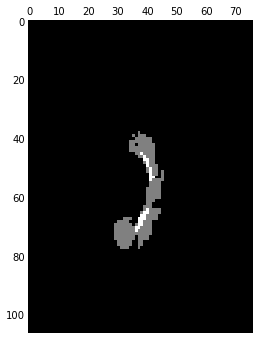

In [35]:
plt.matshow(im, cmap=cm.gray)

In [36]:
sl_from_file = nib.trackvis.read('./csa_white_matter.trk', points_space='rasmm')

In [37]:
all_sl = [s[0] for s in sl_from_file[0]]

In [38]:
xform_sl = [s for s in dtu.move_streamlines(all_sl, np.linalg.inv(hardi_affine)) if s.shape[0]>10]

In [39]:
len(xform_sl)

499293

In [40]:
select_sl = dts.select_by_rois(xform_sl, [warped_midsag.astype(bool)], [True])

In [41]:
t0 = time.time()
select_sl = [s for s in select_sl]
t1 = time.time()
print(t1 - t0)

63.2249600887


In [42]:
len(select_sl)

96121

In [43]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

In [44]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.line(select_sl, line_colors(select_sl)))
fvtk.record(ren, n_frames=1, out_path='callosal_tracks.png', size=(600, 600))
fvtk.show(ren)

In [45]:
import IPython.display as display

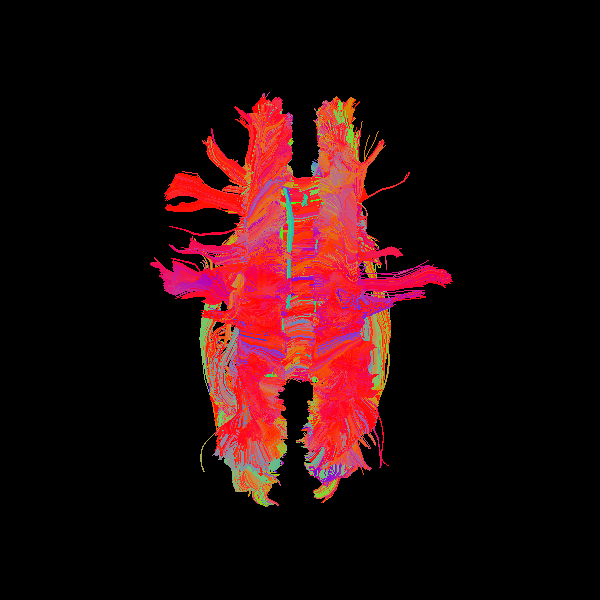

In [46]:
display.Image(filename='callosal_tracks.png')

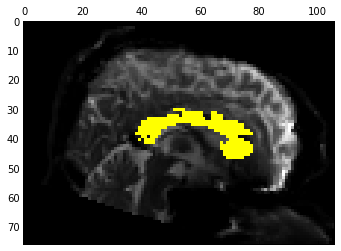

In [47]:
newarray = filled_warped_midsag.astype(float)
newarray = np.sum(newarray,0)
newarray[newarray==0]=np.nan
fig,ax = plt.subplots(1)
ax.matshow(np.rot90(mean_b0[40,:,:]),cmap=cm.gray, vmin=100, vmax = 5000)
ax.matshow(np.rot90(newarray), cmap=cm.autumn, vmin=0, vmax = 1)